# Processing the airports
First, we remove NaN's and \\N values from the dataset, but only where it matters, i.e. at IATA (airport code), latitude, longitude, country and city

In [11]:
import pandas as pd

cols = ["id", "city", "country", "IATA", "ICAO", "latitude", "longitude", "altitude", "timezone", "DST", "Tz database time zone", "type", "source"]
cols_to_remove = ["ICAO", "altitude", "timezone", "DST", "Tz database time zone", "type", "source"]
airports = pd.read_csv('data/airports.csv', index_col=0, names=cols, header=None)
airports = airports.drop(cols_to_remove, axis=1)
print("Length of airports before sorting: ", len(airports))

subset = ["IATA", "latitude", "longitude", "country", "city"]
airports = airports.dropna(subset=subset)
for col in subset:
    airports = airports[airports[col] != "\\N"]
    
print("Length of airports after sorting: ", len(airports))

Length of airports before sorting:  7698
Length of airports after sorting:  6033


Next, we make a dictionary mapping from country to continent, such that we can add continent to the above dataframe.

In [12]:
continents = pd.read_csv('data/continents.csv')
## make a dictionary of country to continent
country_to_continent = {}
for index, row in continents.iterrows():
    country = row['Entity']
    country_to_continent[row['Entity']] = row['Continent']
    
## show the first 5 entries of the dictionary
print("Example of country to continent dictionary:")
dict(list(country_to_continent.items())[0:5])

Example of country to continent dictionary:


{'Abkhazia': 'Asia',
 'Afghanistan': 'Asia',
 'Akrotiri and Dhekelia': 'Asia',
 'Aland Islands': 'Europe',
 'Albania': 'Europe'}

Similarily, we make a dictionary that maps from country to BNP, such that this can be added to the dataframe aswell. 
We only consider BNP from 2015, since this also around the time that the reviews are  gathered. 

In [13]:
BNP_per_capita = pd.read_csv('data/gdp-per-capita-worldbank.csv')
BNP_per_capita_2015 = BNP_per_capita[BNP_per_capita["Year"] == 2015]
## make a dictionary of country to BNP per capita
country_to_BNP_per_capita = {}
for index, row in BNP_per_capita_2015.iterrows():
    country = row['Entity']
    country_to_BNP_per_capita[country] = row['GDP per capita, PPP (constant 2017 international $)']
## see first 5 entries of the dictionary
print("Example of country to BNP per capita dictionary:")
dict(list(country_to_BNP_per_capita.items())[0:5])

Example of country to BNP per capita dictionary:


{'Afghanistan': 2108.714,
 'Albania': 11880.598,
 'Algeria': 11751.634,
 'Angola': 7967.104,
 'Antigua and Barbuda': 19345.018}

The data of continents/BNP comes from Our World In Data (owid), and it doesn't match with the country names from the airport dataset. Therefore, we manually have to fix these names. 

In [14]:
countries_from_airports = airports['country'].unique()
countries_from_continents = continents['Entity'].unique()
countries_from_BNP = BNP_per_capita_2015['Entity'].unique()
## make a set of unique countries from continents and BNP
unique_countries = set(countries_from_continents).union(set(countries_from_BNP))
unique_countries = list(unique_countries)

## find the countries that are in airports but not in continents
print("These names should be fixed:")
print("-" * 20)
for country in countries_from_airports:
    if country not in unique_countries:
        print(country)
        
def fix_country_name(name : str) -> str:
    """
    Function for matching up the country names in the airports dataset with the country names in the continents dataset.
    """
    
    if name[:5] == "Congo":
        return "Congo"
    
    if name == "Czech Republic":
        return "Czechia"
    
    if name == "Macedonia":
        return "North Macedonia"
    
    if name == "Swaziland":
        return "Eswatini"
    
    if name == "Micronesia":
        return "Micronesia (country)"
    
    if name == "Burma":
        return "Myanmar"
    
    if name in ["Midway Islands", "US Virgin Islands", "Virgin Islands", "Johnston Atoll", "Wake Island"]:
        return "United States"
    
    if name == "Macau":
        return "China"
    
    if name == "Cocos (Keeling) Islands":
        return "Australia"
    
    if name == "Russian Federation":
        return "Russia"
    
    return name

These names should be fixed:
--------------------
Congo (Brazzaville)
Congo (Kinshasa)
Swaziland
Czech Republic
Macedonia
Midway Islands
Micronesia
Virgin Islands
Macau
Burma
Johnston Atoll
Cocos (Keeling) Islands
Wake Island


We use the fixed country names to go from one dataset to the other. This way, we can confidently attribute the correct continent and BNP to each airport. 

In [15]:
## make a new column in the airports dataset with the continent
airports['continent'] = airports['country'].apply(fix_country_name).map(country_to_continent)
## same for the BNP per capita
airports['BNP per capita'] = airports['country'].apply(fix_country_name).map(country_to_BNP_per_capita)
## if the BNP is a nan, fill it with the mean
airports['BNP per capita'] = airports['BNP per capita'].fillna(airports['BNP per capita'].mean())

## Processing reviews
Now, we are going to look at the dataset of reviews. The reviews contains both text and numerical reviews. However, once again there are discrepancies between the names of the different datasets. This time, the names of each airport differs slightly. Therefore, we want to map each airport name from the "reviews" to the corresponding airport in the "airports" dataset. 
To do this, we will use the Levenshtein distance, which has been implemented in the python package `fuzzywuzzy`. 
##### Optimizing code
Unfortunately, the Levenshtein distance takes some time to run, and we have quite a lot of reviews. But since the same airports have multiple reviews, we don't need to calculate the corresponding name for each review but only for each airport. Therefore, we use the `functools.cache` wrapper which can remember function evaluations. 
This way, we have optimized our code from ~ 3 hours to ~ 5 minutes. 

In [16]:
from fuzzywuzzy import process
from tqdm import tqdm
from functools import cache
tqdm.pandas()

def format_name(name):
    name = name.replace("-", " ")
    ## make first letter in each word uppercase
    name = " ".join([word.capitalize() for word in name.split()])
    return name

@cache
def match_name(name, candidates):
    name = format_name(name)
    if name in candidates:
        return name
    
    ## get the best match
    match, score = process.extractOne(name, candidates)
    if score > 90:
        return match
    
    return None

airportreviews = pd.read_csv("data/airportreviews.csv")
cols_to_keep = ["airport_name", "recommended", "content"]
airportreviews = airportreviews[cols_to_keep]
airportreviews = airportreviews.dropna(subset=cols_to_keep)

candidates = airports['id'].unique()
candidates = tuple(candidates)
airportreviews["matched_name"] = airportreviews["airport_name"].progress_apply(lambda x: match_name(x, candidates))
airportreviews = airportreviews.dropna(subset=["matched_name"])

100%|██████████| 17721/17721 [03:14<00:00, 91.25it/s] 


Next up, we process the text reviews and numerical ratings of each airport. 
Text reviews are processed as a list of strings. 
Numerical ratings comes as 1's or 0's, i.e. "recommend" and "don't recommend". We have found the average of these numerical ratings, which amount to the fraction of positive reviews.
These are added to the "airports" dataset as a new column. 
#### Optimizing code
All this can be done extremely effective using the `groupby`, `apply` and `merge` functions in pandas. 

In [17]:
## for each airport in airports dataframe, insert the average recommendation score from airportsreviews
airportreviews["recommended"] = airportreviews["recommended"].astype(int)
average_recommendation = airportreviews.groupby("matched_name")["recommended"].mean()
reviews_as_list = airportreviews.groupby("matched_name")["content"].apply(list).reset_index()

airports = pd.merge(airports, reviews_as_list, how="left", left_on="id", right_on="matched_name")
airports = pd.merge(airports, average_recommendation, how="left", left_on="id", right_on="matched_name")

## change column name to "average_recommendation"
airports = airports.rename(columns={"recommended": "average_recommendation"})
airports.to_csv("data/airports_cleaned.csv", index=False)

In [20]:
## save to csv
airports.to_csv("data/airports_cleaned.csv", index=False)

Unfortunately, a lot of aiport dont have any reviews. Our dataset contains a total of 6007 airports, but only 299 have reviews. 

In [64]:
airports_in_dataset = airports["id"].unique().tolist()
print("Number of unique airport names in dataset:", len(airports_in_dataset))
airports_in_reviews = airportreviews["matched_name"].unique().tolist()
print("Number of unique airport names in reviews (i.e. number of airports with reviews):", len(airports_in_reviews))
print("-" * 30)

Number of unique airport names in dataset: 6007
Number of unique airport names in reviews (i.e. number of airports with reviews): 299
------------------------------


# Making the graph
To make the graph, we'll use Networkx. We'll format the graph as a dictionary to start of, which can then be passed to Networkx to create an actual graph. First, we'll make a dictionary for all nodes with their attributes (cityname, country, and so on). Each node will have a name according to their IATA (International Air Transport Association) code, which is a unique 3 digit identifier for each airport. 

In [65]:
## make a dictionary of IATA codes
## IATA code is a three-letter code designating many airports around the world
## for each airport, safe relevant information in a dictionary
from tqdm import tqdm

IATA = {}
for index, row in tqdm(airports.iterrows(), total=len(airports)):
    country = row['country']
    
    IATA[row['IATA']] = {
        'city': row['city'],                                                ## city
        'country': country,                                                 ## country
        'latitude': row['latitude'],                                        ## latitude
        'longitude': row['longitude'],                                      ## longitude
        'name': row['id'],                                                  ## name        
        'continent': country_to_continent.get(fix_country_name(country), 'unknown'),    ## continent
        'BNP_per_capita': country_to_BNP_per_capita.get(fix_country_name(country), 'unknown'), ## BNP per capita
    }
    
## save the dictionary to a file
import json
with open('data/IATA.json', 'w') as f:
    json.dump(IATA, f)

100%|██████████| 6033/6033 [00:00<00:00, 15554.47it/s]


Now, lets look at the "flight" dataset, i.e. the dataset over flight connections. Once again, we'll filter this dataset by excluding NaN values and by only considering direct flight. 

In [66]:
cols = ["airline", "airline id", "source airport", "source airport id", "destination airport", "destination airport id", "codeshare", "stops", "equipment"]
flights = pd.read_csv('data/flights.csv', names=cols, header=None)
print("Number of connections before filtering:", len(flights))
flights = flights.dropna(subset=['source airport', 'destination airport'])
flights = flights[flights['stops'] == 0]  ## only direct flights
print("Number of connections after filtering:", len(flights))

Number of connections before filtering: 67663
Number of connections after filtering: 67652


# Making the graph
Now, we can make the graph. First, we'll add all nodes to the graph, and we will then add connections. 
The graph have been visualized using `netwulf`. 
NOTICE: when using `netwulf` we DO NOT consider the spatial position of each node. This will come later. 

In [68]:
## makes a graph of the flights
## the graph is a directed graph since the flights are one way
## nodes are cities, and edges are flights between cities
## the weight of the edge is the number of flights between the cities

import networkx as nx
from tqdm import tqdm
G = nx.DiGraph()

print("Making nodes with attributes..")
for iata, data in tqdm(IATA.items()):
    G.add_node(
        iata, 
        city=data['city'], 
        country=data['country'], 
        latitude=data['latitude'], 
        longitude=data['longitude'], 
        continent=data['continent'],
        name=data['name'],
        group=data['continent']
        )

print("Making edges..")
for index, row in tqdm(flights.iterrows(), total=flights.shape[0]):
    source = row['source airport']
    dest = row['destination airport']
    if source in IATA.keys() and dest in IATA.keys():
        if G.has_edge(source, dest):
            G[source][dest]['weight'] += 1
        else:
            G.add_edge(source, dest, weight=1)
            
## remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

## 
import pickle
with open('data/graphnetwork.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

Making nodes with attributes..


100%|██████████| 6033/6033 [00:00<00:00, 480320.34it/s]


Making edges..


100%|██████████| 67652/67652 [00:02<00:00, 25872.08it/s]

Number of nodes:  3256
Number of edges:  37038


Each color is a different continent. 
Unfortunately, it is not possible (as far as we know) in Netwulf to make a legend for the classes. But, this can be accomplished later, when drawing the nodes on an actual map. 

Netwulf also allows us to visualize a graph with given (x,y) coordinates. BUT it doesn't allow us to draw great circle arcs, i.e. the seeminly non-straight patterns that planes fly in when visualized on a 2d map. Therefore, this will be accomplished later. 

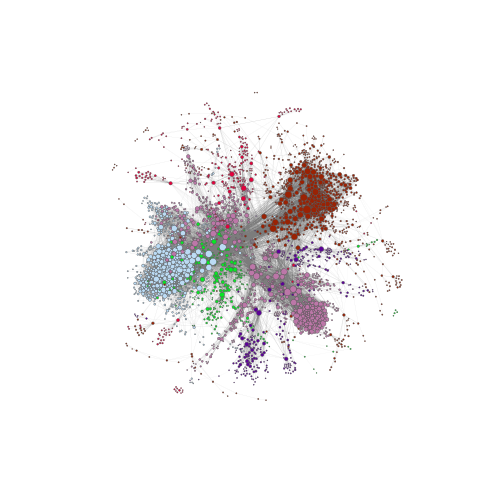

In [77]:
import netwulf
import matplotlib.pyplot as plt
config = {'zoom': 0.6,
 'node_charge': -45,
 'node_gravity': 0.1,
 'link_distance': 15,
 'link_distance_variation': 0,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#79aaa0',
 'node_stroke_color': '#555555',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': True,
 'node_size': 31.6736077232895,
 'node_stroke_width': 1,
 'node_size_variation': 0.30996494265163715,
 'link_color': '#7c7c7c',
 'link_width': 2,
 'link_alpha': 0.5,
 'link_width_variation': 1.079538259141508,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}
network, config =netwulf.visualize(G, config=config)
fig, ax = netwulf.draw_netwulf(network)
plt.savefig("network.png")

# Visualizing the graph
In this part, we will make a few visualizations of our network. 
We have a big focus on the fact that our graph-nodes have (x,y) coordinates which can be visualized on a map. 

In [7]:
import json
import pickle
from gcmap import GCMapper, Gradient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import PowerNorm, LogNorm, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
import matplotlib.patches as mpatches

## load the IATA data
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)

We use a relevant python package, `gcmap`, to visualize the great circles that the planes fly in. 

In [8]:
## make G undirected
G_undirect = G.to_undirected(reciprocal=True)
source_lon, source_lat, destination_lon, destination_lat, nb_flights = [], [], [], [], []
edges = G_undirect.edges(data=True)
for u, v, data in edges:
    if u != v:
        source_lon.append(IATA[u]['longitude'])
        source_lat.append(IATA[u]['latitude'])
        destination_lon.append(IATA[v]['longitude'])
        destination_lat.append(IATA[v]['latitude'])
        nb_flights.append(data['weight'])
        
grad = Gradient(((0, 0, 0, 0), (0.5, 204, 0, 153), (1, 255, 204, 230)))
gcm = GCMapper(cols=grad, height=2000, width=4000)
gcm.set_data(source_lon, source_lat, destination_lon, destination_lat, nb_flights)
img = gcm.draw()
img.save('images/flightmap.png')

To make things more manageable, we plot the nodes in another plot with a unique color for each continent.
The size of each node is proportional to the degree of the node. 

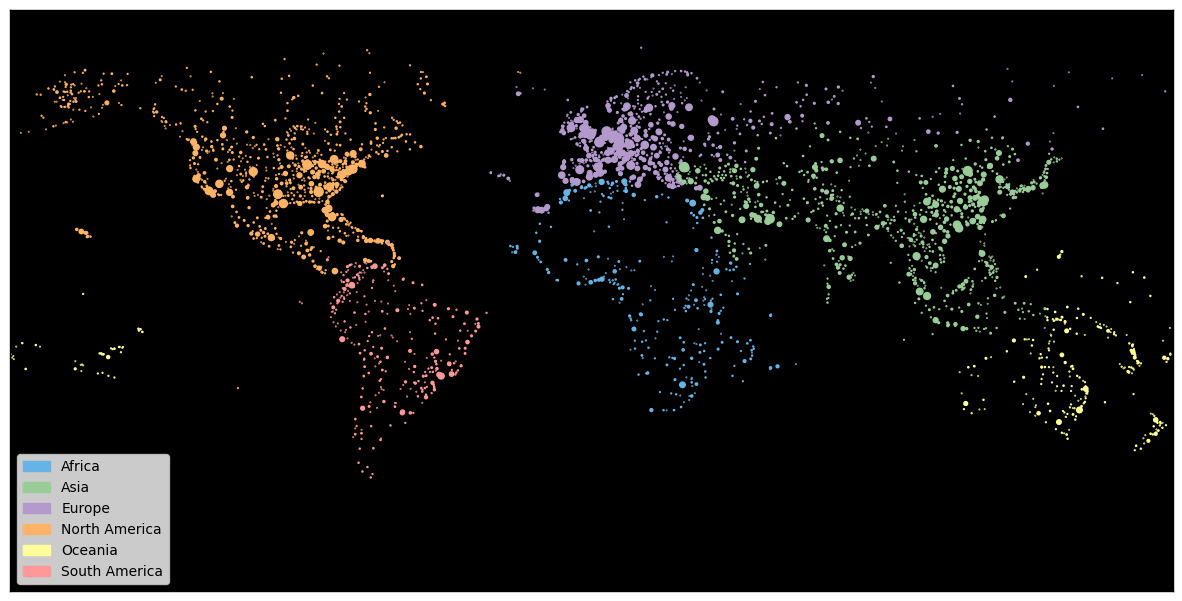

In [10]:
## create a basemap
fig, ax = plt.subplots(figsize=(15, 10))
resolution = "c"
m = Basemap(lon_0=0, resolution=resolution)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color="lightgrey", linewidth=0.3)

continent_to_color = {
    'Africa': (0.4, 0.7, 0.9), 
    'Asia': (0.6, 0.8, 0.6), 
    'Europe': (0.7, 0.6, 0.8), 
    'North America': (1.0, 0.7, 0.4), 
    'Oceania': (1.0, 1.0, 0.6), 
    'South America': (1.0, 0.6, 0.6)
    }

## plot the nodes
lons = [IATA[node]['longitude'] for node in G_undirect.nodes()]
lats = [IATA[node]['latitude'] for node in G_undirect.nodes()]
sizes = [0.2 * G_undirect.degree(node) for node in G_undirect.nodes()]
colors = [continent_to_color[IATA[node]['continent']] for node in G_undirect.nodes()]
x, y = m(lons, lats)
m.scatter(x, y, c=colors, s=sizes)
plt.legend(handles=[mpatches.Patch(color=continent_to_color[continent], label=continent) for continent in continent_to_color])
plt.savefig('images/flightmap_nodes.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Visualizing the numerical ratings
We really wanted to visualize how the airports around the globe is rated. We wanted to paint the whole worldmap depending on the quality of aiports in the different regions. We considered multiple ways of doing it, and we ended up agreeing on doing regression to interpolate this score based on nearby airports using a Gaussian Process. 
The good thing about a Gaussian Process is that it also reports an error in each point, and we can therefore color in areas where the regression model in uncertain about the target value. This would be places where there is no airport close by with any reviews. 

So, we made two functions, one for fitting a Gaussian Process to the (x,y) coordinates, and one for plotting the results.

In [69]:
def fit_gp(X, y, resolution=1000, length_scale=15):
    kernel = RBF(length_scale=length_scale, length_scale_bounds="fixed")
    model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)
    model.fit(X, y)

    lats, lons = X[:, 0], X[:, 1]
    min_lats, max_lats = -90, 90
    min_lons, max_lons = -180, 180

    lats = np.linspace(min_lats, max_lats, resolution)
    lons = np.linspace(min_lons, max_lons, resolution)
    lats, lons = np.meshgrid(lats, lons)
    Xmesh = np.vstack([lats.ravel(), lons.ravel()]).T
    ymesh, uncertainty = model.predict(Xmesh, return_std=True)
    uncertainty = uncertainty.reshape((resolution, resolution))
    ymesh = ymesh.reshape((resolution, resolution))
    
    return lons, lats, ymesh, uncertainty

def visualize_gp(lons, lats, ymesh, uncertainty, max_uncertainty, title="", label=""):
    ## make a grey cmap, that always returns grey
    min_ymesh, max_ymesh = np.min(ymesh), np.max(ymesh)
    print(f"max: {max_ymesh}, min: {min_ymesh}")
    
    cmap_grey = LinearSegmentedColormap.from_list(
        "grey", 
        [(min_ymesh, "grey"), (max_ymesh, "grey")]
    )
    
    c = ["red","orange","yellow","palegreen","green","darkgreen"]
    cmap=LinearSegmentedColormap.from_list('rg',c, N=256)
    m = Basemap(lon_0=0)
    
    def is_water(lat, lon):
        return not m.is_land(lon, lat)

    resolution, _ = ymesh.shape
    try: 
        ywater = np.load(f"data/ywater{resolution}.npy")
    except:
        ywater = np.zeros_like(ymesh)
        for i in tqdm(range(ymesh.shape[0])):
            for j in range(ymesh.shape[1]):
                if is_water(lats[i, j], lons[i, j]):
                    ywater[i, j] = 1
        np.save(f"data/ywater{resolution}.npy", ywater)
        
    watermasked = np.ma.masked_where(ywater == 1, ymesh)
    uncertain_or_water_masked = np.ma.masked_where((uncertainty < max_uncertainty) | (ywater == 1), np.ones_like(ymesh))
    
    fig, ax = plt.subplots(figsize=(15, 10))
    m.pcolormesh(lons, lats, watermasked, cmap=cmap, shading='auto')
    m.colorbar(location="bottom", label=label)
    m.pcolor(lons, lats, uncertain_or_water_masked, cmap=cmap_grey)
    grey_patch = mpatches.Patch(color='grey', label='Areas with high uncertainty / low density of airports')
    plt.legend(handles=[grey_patch])
    plt.title(title)
    plt.savefig(f'images/{title}', dpi=300, bbox_inches='tight')
    plt.show()

max: 1.0, min: 0.0


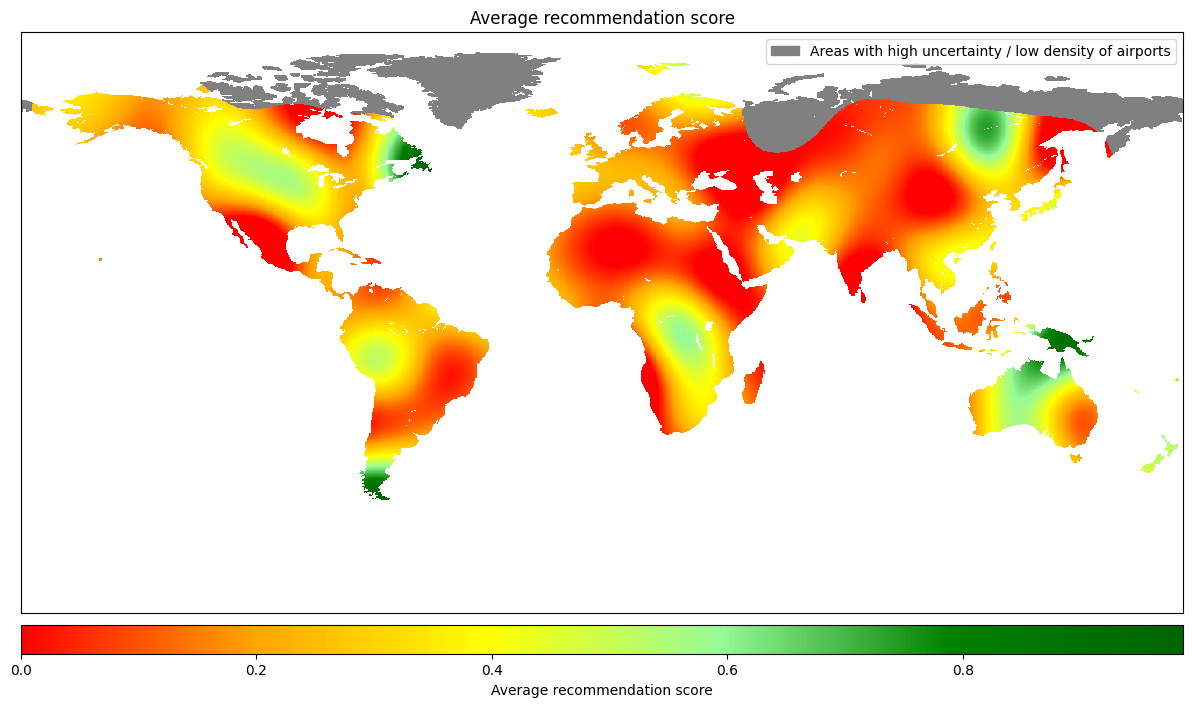

In [76]:
airports = pd.read_csv("data/airports_cleaned.csv", index_col=0)
airports_all_reviews = airports.dropna(subset=["average_recommendation"])
X = airports_all_reviews[["latitude", "longitude"]].to_numpy()
avg_rec = airports_all_reviews["average_recommendation"].to_numpy()

lons, lats, ymesh, uncertainty = fit_gp(X, avg_rec, length_scale=15, resolution=1000)
max_rec_uncertainty = np.percentile(uncertainty, 50)
ymesh = np.clip(ymesh, 0, 1)
visualize_gp(
    lons, 
    lats, 
    ymesh, 
    uncertainty, 
    max_rec_uncertainty, 
    title="Average recommendation score", 
    label="Average recommendation score"
    )

max: 1.0, min: 0.0


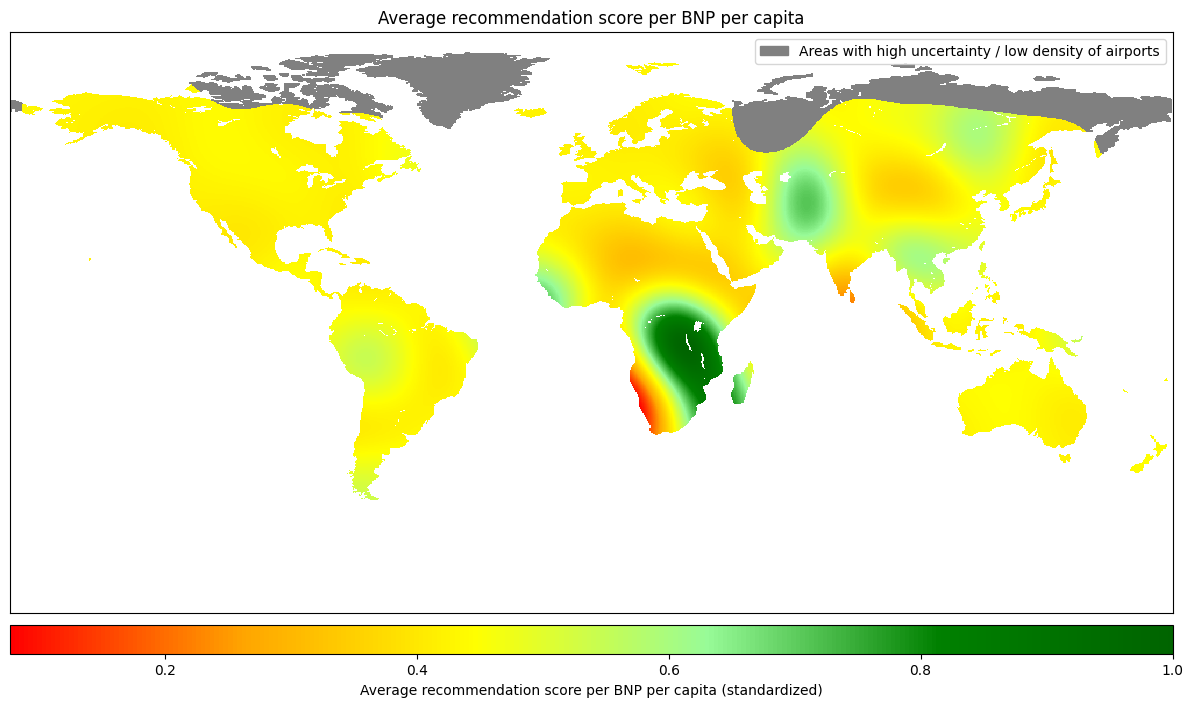

In [94]:
bnp = airports_all_reviews["BNP per capita"].to_numpy()
avg_rec_per_bnp = avg_rec / bnp

lons, lats, ymesh, uncertainty = fit_gp(X, avg_rec_per_bnp, length_scale=15, resolution=1000)
## standardize ymesh between 0 and 1. dont clip it
min_ymesh, max_ymesh = np.min(ymesh), np.max(ymesh)
ymesh = (ymesh - min_ymesh) / (max_ymesh - min_ymesh)
max_rec_per_bnp_uncertainty = np.percentile(uncertainty, 50)
visualize_gp(
    lons, 
    lats, 
    ymesh, 
    uncertainty, 
    max_rec_per_bnp_uncertainty, 
    title="Average recommendation score per BNP per capita", 
    label="Average recommendation score per BNP per capita (standardized)"
    )